In [25]:
import os
import shutil
import random
import numpy as np

curr_dir = os.getcwd()

data_folder = os.path.join(curr_dir, "data")
train_folder = os.path.join(curr_dir, "train")
test_folder = os.path.join(curr_dir, "test")

# List all folders in the data directory
folders = os.listdir(data_folder)

# Shuffle the folders
random.shuffle(folders)

# Calculate the split index
split_index = int(0.6 * len(folders))

# Split folders into train and test sets
train_folders = folders[:split_index]
test_folders = folders[split_index:]

# Function to move data into train or test directory
def move_data(source_folder, dest_folder, folders):
    for folder in folders:
        source_path = os.path.join(source_folder, folder)
        dest_path = os.path.join(dest_folder, folder)
        shutil.move(source_path, dest_path)

# Move train data
move_data(data_folder, train_folder, train_folders)

# Move test data
move_data(data_folder, test_folder, test_folders)


In [26]:
from PIL import Image

def load_data(folder_path):
    """
    Load data from the folder structure.
    
    Args:
    - folder_path: Path to the main folder containing subfolders with images
    
    Returns:
    - input_mix: List of input mix spectrogram images
    - sources: List of lists, where each inner list contains three source spectrogram images corresponding to each input mix
    """
    input_mix = []
    sources = []

    # Iterate through each folder in the main folder
    for folder in os.listdir(folder_path):
        folder_name = folder.split("_")[1]  # Extract id_x from folder name
        print(folder_name)
        if os.path.isdir(os.path.join(folder_path, folder)):
            input_mix_path = os.path.join(folder_path, folder, f"id_{folder_name}_mix.png")
            source_music_path = os.path.join(folder_path, folder, f"id_{folder_name}_music.png")
            source_sp0_path = os.path.join(folder_path, folder, f"id_{folder_name}_sp0.png")
            source_sp1_path = os.path.join(folder_path, folder, f"id_{folder_name}_sp1.png")
            print(input_mix_path)
            
            # Load images
            input_mix_img = Image.open(input_mix_path).convert("RGB")
            source_music_img = Image.open(source_music_path).convert("RGB")
            source_sp0_img = Image.open(source_sp0_path).convert("RGB")
            source_sp1_img = Image.open(source_sp1_path).convert("RGB")

            # Resize images if needed
            input_mix_img = input_mix_img.resize((496, 369))
            source_music_img = source_music_img.resize((496, 369))
            source_sp0_img = source_sp0_img.resize((496, 369))
            source_sp1_img = source_sp1_img.resize((496, 369))

            # Convert images to numpy arrays and normalize pixel values
            input_mix_arr = np.array(input_mix_img) / 255.0
            source_music_arr = np.array(source_music_img) / 255.0
            source_sp0_arr = np.array(source_sp0_img) / 255.0
            source_sp1_arr = np.array(source_sp1_img) / 255.0

            # Append to lists
            input_mix.append(input_mix_arr)
            sources.append([source_music_arr, source_sp0_arr, source_sp1_arr])

    return input_mix, sources

train_input_mix, train_sources = load_data(train_folder)
test_input_mix, test_sources = load_data(test_folder)

# Convert lists to numpy arrays
train_input_mix = np.array(train_input_mix)
train_sources = np.array(train_sources)

test_input_mix = np.array(test_input_mix)
test_sources = np.array(test_sources)


0
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_0\id_0_mix.png
10
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_10\id_10_mix.png
101
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_101\id_101_mix.png
102
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_102\id_102_mix.png
103
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_103\id_103_mix.png
104
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_104\id_104_mix.png
106
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_106\id_106_mix.png
107
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_107\id_107_mix.png
109
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_109\id_109_mix.png
111
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_111\id_111_mix.png
113
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_113\id_113_mix.png
115
c:\Users\Matt\Desktop\School\575subsectionSoundSep\train\idx_115\id_115_mix.png
1

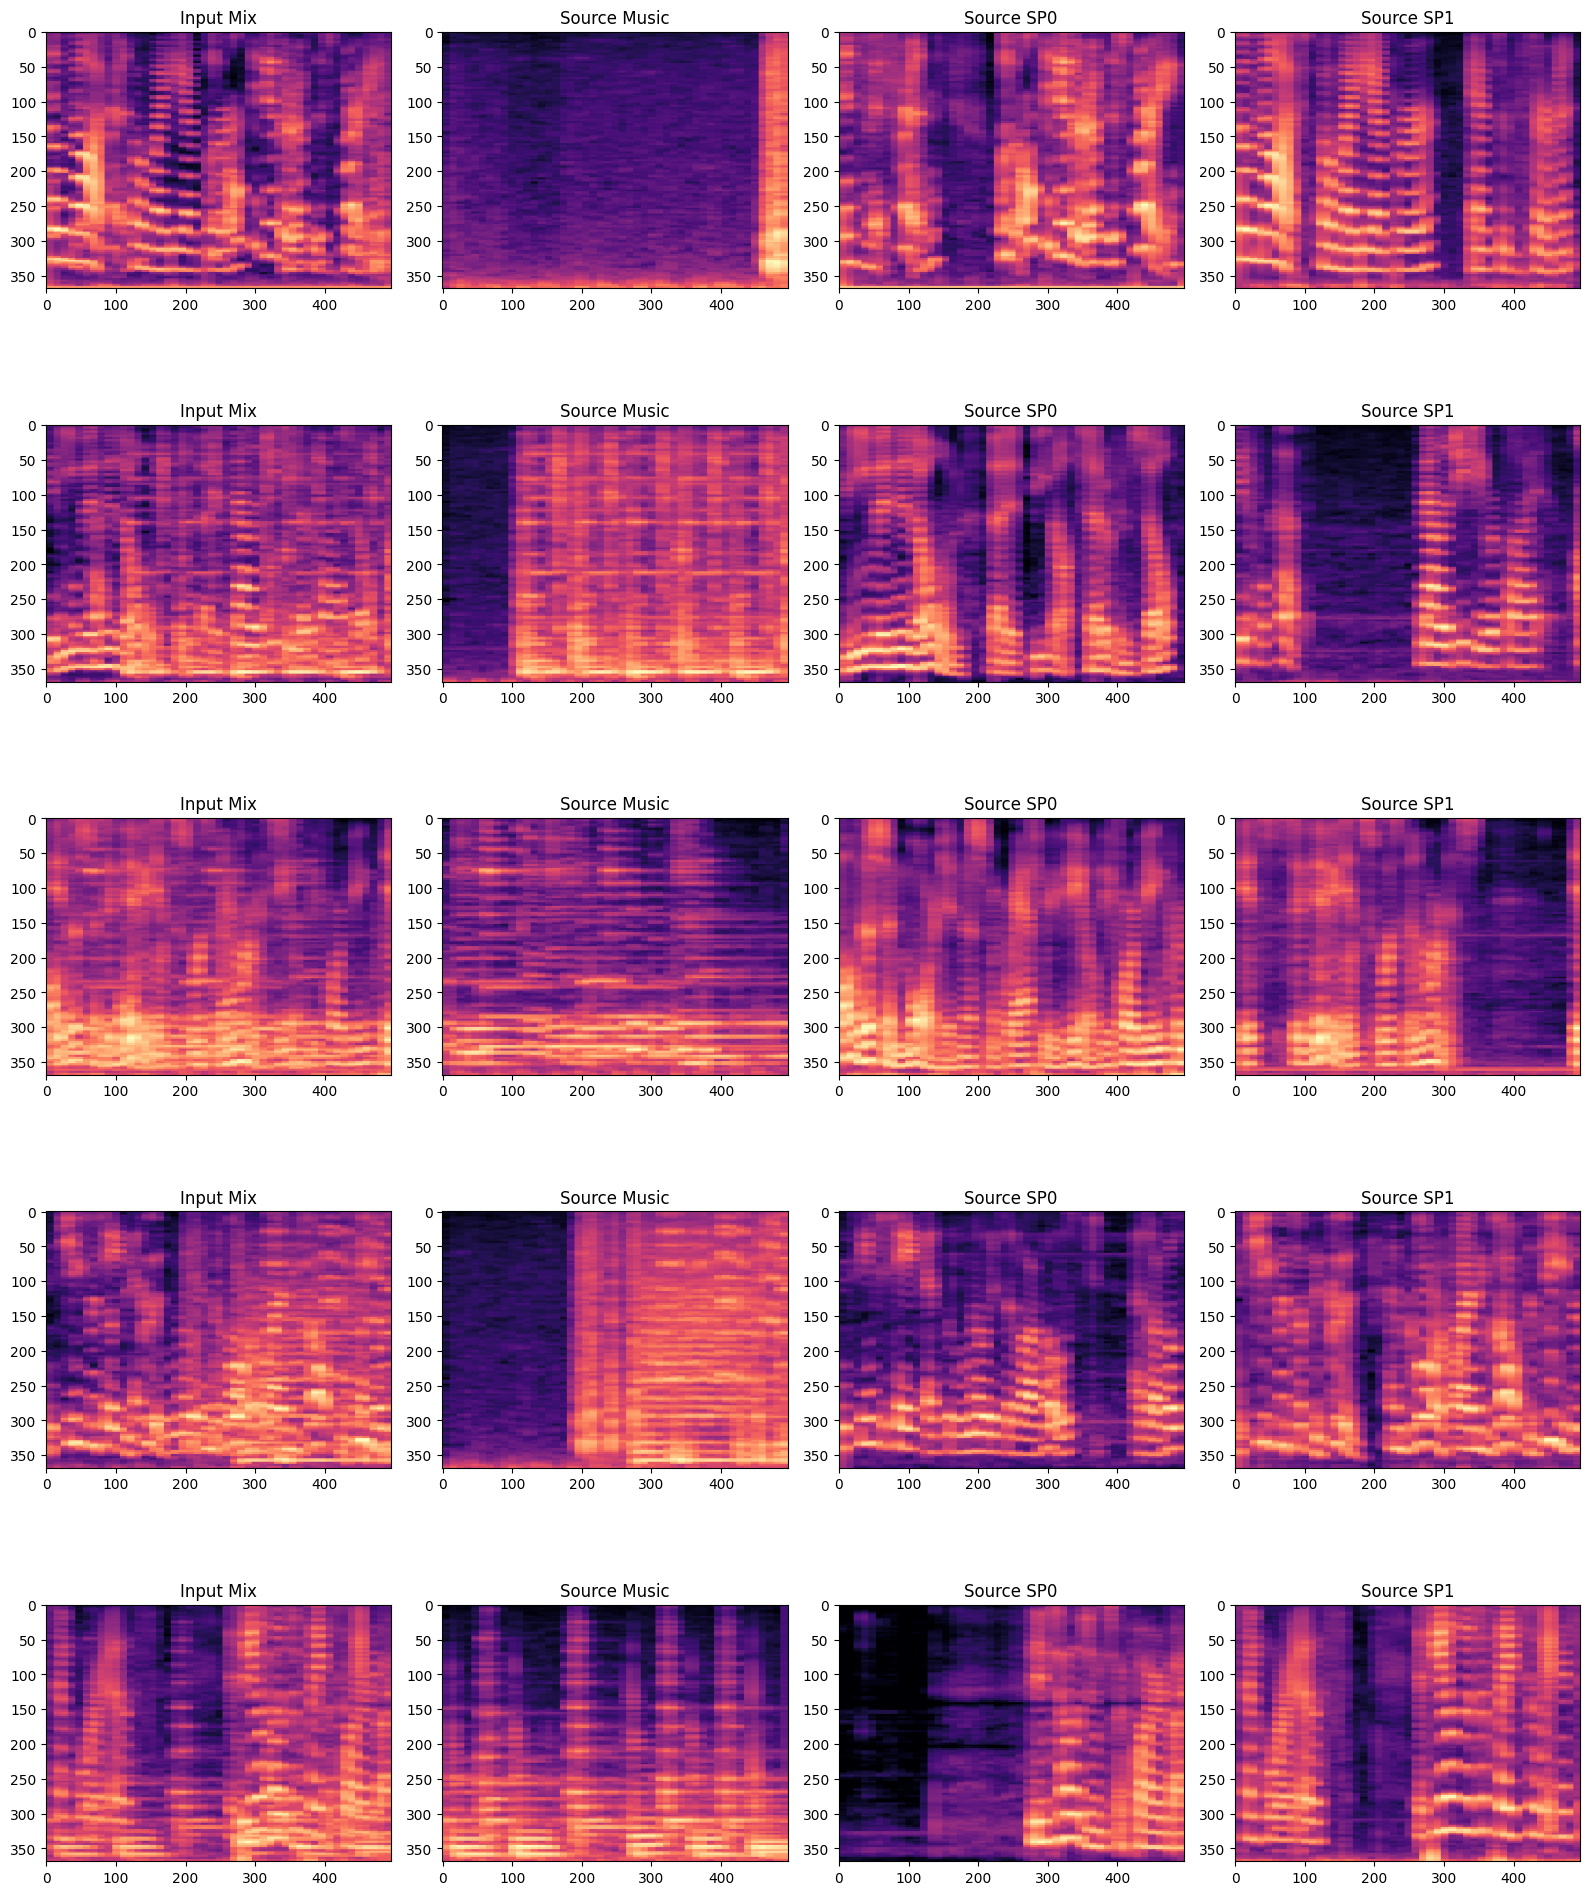

In [27]:
import matplotlib.pyplot as plt

# Visualize a few input mix and source images
num_samples = len(test_input_mix)
num_visualize = min(5, num_samples)  # Visualize up to 5 samples

fig, axes = plt.subplots(num_visualize, 4, figsize=(16, num_visualize * 4))

for i in range(num_visualize):
    input_mix_img = test_input_mix[i]
    source_music_img, source_sp0_img, source_sp1_img = test_sources[i]
    
    axes[i, 0].imshow(input_mix_img)
    axes[i, 0].set_title(f'Input Mix')    #TODO add ID here but I know those sources go with those mixtures even if idk ids

    axes[i, 1].imshow(source_music_img)
    axes[i, 1].set_title('Source Music')

    axes[i, 2].imshow(source_sp0_img)
    axes[i, 2].set_title('Source SP0')

    axes[i, 3].imshow(source_sp1_img)
    axes[i, 3].set_title('Source SP1')

plt.tight_layout()
plt.show()


In [28]:
# Create TensorFlow Dataset objects
import tensorflow as tf
print("Train input mix shape:", train_input_mix.shape)
print("Train sources shape:", train_sources.shape)  # extra 3 just means we have 3 targets
print("Train input mix dtype:", train_input_mix.dtype)
print("Train sources dtype:", train_sources.dtype)

print("Test input shape", test_input_mix.shape)

gpu_devices = tf.config.experimental.list_physical_devices("GPU") # to solve overfilling VRAM
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

batch_size = 32  # Adjust as needed

train_dataset = tf.data.Dataset.from_tensor_slices((train_input_mix, train_sources)).shuffle(buffer_size=len(train_input_mix)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_input_mix, test_sources)).batch(batch_size)

Train input mix shape: (480, 369, 496, 3)
Train sources shape: (480, 3, 369, 496, 3)
Train input mix dtype: float64
Train sources dtype: float64
Test input shape (320, 369, 496, 3)


In [29]:
import math
from keras import layers
from keras import Model
from keras.applications.efficientnet import preprocess_input    # TODO how does this apply to efficientnet now?
from keras.callbacks import LearningRateScheduler

img_height = 369
img_width = 496
num_channels = 3    # RGB
input_shape = (img_height, img_width, num_channels)

train_samples = 480
test_samples = 320

pre_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = "imagenet",
    input_shape = input_shape
)

# freeze base
pre_model.trainable = False

# Add custom layers on top
x = layers.GlobalAveragePooling2D()(pre_model.output)
x = layers.Dense(512, activation='relu')(x)

# Output layers for three spectrograms
output1 = layers.Dense(369 * 496 * 3, activation='sigmoid')(x)  # this is adding a HUGE amount of complexity & trainable params methinks
output2 = layers.Dense(369 * 496 * 3, activation='sigmoid')(x)
output3 = layers.Dense(369 * 496 * 3, activation='sigmoid')(x)

# Reshape outputs to match spectrogram size
output1 = tf.reshape(output1, (-1, 369, 496, 3))
output2 = tf.reshape(output2, (-1, 369, 496, 3))
output3 = tf.reshape(output3, (-1, 369, 496, 3))

# Define model
model = Model(inputs=pre_model.input, outputs=[output1, output2, output3])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 369, 496, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 369, 496, 3)  0           ['input_4[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 185, 248, 24  648         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

In [36]:
def custom_loss(y_true, y_pred):
    # Reshape y_true and y_pred to (batch_size, num_sources, height, width, channels)

    # Compute separate losses for each source
    losses = []
    for i in range(3):
        print(y_true[:, i].shape)
        print(y_pred[i].shape)
        loss = tf.losses.mean_squared_error(y_true[:, i], y_pred[i])
        losses.append(loss)

    # Combine losses (e.g., mean or sum)
    total_loss = tf.reduce_mean(losses)  # you can also use tf.reduce_sum or other aggregation methods

    return total_loss

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=custom_loss)

## callbacks
# model checkpoint
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', mode='max', save_best_only=True)  # SDR loss is better higher

# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # Monitor the validation loss
                                        patience=12,          # Number of epochs with no improvement after which training will be stopped
				        restore_best_weights=True)      # Restore best weights from that period

# learning rate scheduler
def scheduler(epoch, lr):
	initial_lrate = 0.001
	drop = 0.1
	epochs_drop = 10
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lr_schedule = LearningRateScheduler(scheduler)

history = model.fit(
      train_dataset,
      steps_per_epoch=int(np.ceil(train_samples / float(batch_size))),
      epochs=50,
      validation_data=test_dataset,
      validation_steps=int(np.ceil(test_samples / float(batch_size))),
      callbacks = [cp, es, lr_schedule],
      verbose=1)

Epoch 1/50
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)
(None, 369, 496, 3)
(369, 496, 3)


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/custom_loss_1/BroadcastGradientArgs_2' defined at (most recent call last):
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Matt\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Matt\AppData\Local\Temp\ipykernel_13488\3144321682.py", line 39, in <module>
      history = model.fit(
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\Matt\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/custom_loss_1/BroadcastGradientArgs_2'
Incompatible shapes: [32,496,3] vs. [32,369,496,3]
	 [[{{node gradient_tape/custom_loss_1/BroadcastGradientArgs_2}}]] [Op:__inference_train_function_254411]